## Code to Filter out non speech video segement from the actual audioset strong annotations

In [31]:
import pandas as pd

# Load the TSV file
# Replace 'your_file.tsv' with the path to your TSV file
df = pd.read_csv('/disk1/audioset/annotations/audioset_train_strong.tsv', sep='\t')

# Function to extract YouTube ID and start time
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds

# Apply the function to extract YTID and start_seconds
df['YTID'], df['start_seconds'] = zip(*df['segment_id'].map(extract_ytid_and_start))

# Calculate end_seconds from start_seconds
df['end_seconds'] = df['start_seconds'] + 10.0

# Group by YTID, start_seconds, and end_seconds and aggregate labels
result = df.groupby(['YTID', 'start_seconds', 'end_seconds'])['label'].apply(lambda x: ',"' + ','.join(x) + '"').reset_index()

speech_labels = ['/m/02zsn','/m/05zppz','/m/07qfr4h','/m/09x0r','/m/0brhx','/m/0ytgt']

for label in speech_labels:
    # if label not in result['label'] coloumn then only consider that row
    result = result[~result['label'].str.contains(label)]

# Rename columns to match the required output format
result.rename(columns={
    'YTID': 'YTID',
    'start_seconds': 'start_seconds',
    'end_seconds': 'end_seconds',
    'label': 'positive_labels'
}, inplace=True)

# Save to CSV file
# Replace 'output_file.csv' with the path where you want to save the CSV file
result.to_csv('/disk1/audioset/annotations/audioset_train_strong.csv', index=False)


## Code to check num downloaded from files that we have

In [32]:
import pandas as pd
import os
def get_files_downloaded(split_type, u_l,l_l,base_dir):
    dir = base_dir + split_type+'/videos/'
    files = os.listdir(dir)
    ann_csv_file = base_dir + f'annotations/audioset_{split_type}_strong.csv'
    df = pd.read_csv(ann_csv_file)
    df['YTID'] = df['YTID'].apply(lambda x: ''.join(e for e in x if e.isalnum()))
    files = [f.split('.')[0] for f in files]
    if split_type=='eval':        
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()
    else:
        # select only rows from lower and upper limit
        df = df[l_l:u_l]
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()
    
if __name__ == '__main__':
    # split_type = 'eval' or 'train'
    split_type = 'train'
    base_dir = '/disk1/audioset/'
    for l_l in range(0,60000,10000):
        u_l = l_l + 10000
        print(f"{l_l} to {u_l} -> {len(get_files_downloaded(split_type, u_l, l_l, base_dir))}")
    print(f"Eval\n 0 to 9929 -> {len(get_files_downloaded('eval', 0, 9929, base_dir))}")

0 to 10000 -> 7736
10000 to 20000 -> 7426
20000 to 30000 -> 2025
30000 to 40000 -> 0
40000 to 50000 -> 0
50000 to 60000 -> 0
Eval
 0 to 9929 -> 7259


## Analysis and Filtering of the data for selecting the noise classes

In [33]:
import pandas as pd
import os
sets = ['train', 'eval']
ann_files_real = ['audioset_train_strong.tsv', 'audioset_eval_strong.tsv']
ann_files_speech_rem = ['audioset_train_strong.csv', 'audioset_eval_strong.csv']
base_dir = '/disk1/audioset/annotations/'
mid_to_label = pd.read_csv(base_dir + 'mid_to_display_name.tsv', sep='\t', names=['mid', 'label'])
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds

def get_filtered_df(ann_files_real, ann_files_speech_rem):
    dfs_filtered = {}
    for split_type in sets:
        df_real = pd.read_csv(base_dir + ann_files_real[sets.index(split_type)], sep='\t')
        df_speech_rem = pd.read_csv(base_dir + ann_files_speech_rem[sets.index(split_type)])
        df_real['YTID'], df_real['start_seconds'] = zip(*df_real['segment_id'].map(extract_ytid_and_start))
        df_real['end_seconds'] = df_real['start_seconds'] + 10.0
        # select YTID's that are present in df_speech_rem only
        print(f"Num IDs in {split_type} -> {len(df_real['YTID'].unique())}")
        df_real = df_real[df_real['YTID'].isin(df_speech_rem['YTID'])]
        print(f"{split_type} -> {len(df_real['YTID'].unique())}")
        dfs_filtered[split_type] = df_real
    return dfs_filtered

def get_samples_greater_than_given_len(df, len):
    return df[df['end_time_seconds'] - df['start_time_seconds'] > len]

def filter_samples_with_given_labels(df, labels):
    for label in labels:
        df = df[~df['label'].str.contains(label)]
    return df

def get_samples_with_mean_label_time_greater_than_given_len(df, length):
    # Check if necessary columns exist
    if 'label' not in df.columns or 'start_time_seconds' not in df.columns or 'end_time_seconds' not in df.columns:
        raise ValueError("DataFrame must contain 'label', 'start_time_seconds', and 'end_time_seconds' columns")

    # Calculate mean time for each label
    df['duration'] = df['end_time_seconds'] - df['start_time_seconds']
    label_vs_mean_time = df.groupby('label')['duration'].mean()

    # Filter labels with mean time greater than the specified length
    len_filtered_labels = label_vs_mean_time[label_vs_mean_time > length].index

    # Select only those rows that have the filtered labels
    df_filtered = df[df['label'].isin(len_filtered_labels)]

    # also print top 5 frequent labels according to num samples in the filtered df for each bin of 1sec
    # print(f"Top 5 frequent labels in {length} sec bins")
    # for i in range(0, int(df_filtered['end_time_seconds'].max()), 1):
    #     df_filtered_i = df_filtered[(df_filtered['end_time_seconds'] >= i) & (df_filtered['end_time_seconds'] < i+1)]
    #     print(f"Bin {i} to {i+1}")
    #     # convert labels to display names using mid_to_label
    #     df_filtered_i['label'] = df_filtered_i['label'].apply(lambda x: mid_to_label[mid_to_label['mid']==x]['label'].values[0])
    #     print(df_filtered_i['label'].value_counts().head(15))

    return df_filtered

def rem_samples_from_mids_to_avoid (df, mids_to_avoid):
    for mid in mids_to_avoid:
        df = df[~df['label'].str.contains(mid)]
    return df

def get_num_samples_for_given_labels(df, labels):
    # label vs num_samples to be returned
    label_vs_num_samples = {}
    for label in labels:
        label_vs_num_samples[label] = len(df[df['label'].str.contains(label)])
    return label_vs_num_samples

dfs = get_filtered_df(ann_files_real, ann_files_speech_rem)

Num IDs in train -> 103463
train -> 54477
Num IDs in eval -> 16996
eval -> 16996


### Plotting labels distribution

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_binned_bar_graph_of_meantime_to_num_labels_num_samples(df, bin_size=1):
    # Check if necessary columns exist
    if 'label' not in df.columns or 'start_time_seconds' not in df.columns or 'end_time_seconds' not in df.columns:
        raise ValueError("DataFrame must contain 'label', 'start_time_seconds', and 'end_time_seconds' columns")

    # Calculate duration for each row
    df['duration'] = df['end_time_seconds'] - df['start_time_seconds']
    
    # Calculate mean duration for each label
    label_vs_mean_time = df.groupby('label')['duration'].mean()
    
    # Bin the mean durations
    bins = range(0, int(label_vs_mean_time.max()) + bin_size, bin_size)
    binned = pd.cut(label_vs_mean_time, bins)

    # Calculate number of labels in each bin
    num_labels_per_bin = binned.value_counts().sort_index()

    # Calculate number of samples in each bin
    df['binned_mean_time'] = pd.cut(df['duration'], bins)
    num_samples_per_bin = df['binned_mean_time'].value_counts().sort_index()

    # Plot 1: Mean time vs number of labels
    plt.figure(figsize=(10, 6))
    num_labels_per_bin.plot(kind='bar')
    plt.title('Mean Time vs Number of Labels')
    plt.xlabel('Mean Time Bins')
    plt.ylabel('Number of Labels')
    plt.tight_layout()
    plt.show()

    # Plot 2: Mean time vs number of samples
    plt.figure(figsize=(10, 6))
    num_samples_per_bin.plot(kind='bar')
    plt.title('Mean Time vs Number of Samples')
    plt.xlabel('Mean Time Bins')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

    # Calculate number of samples for each label
    num_samples_per_label = df['label'].value_counts()

    # If mid_to_label is provided, map labels to their names
    if mid_to_label is not None:
        num_samples_per_label = num_samples_per_label.reset_index()
        num_samples_per_label = num_samples_per_label.rename(columns={'index':'label', 'label':'count'})
        num_samples_per_label['label'] = num_samples_per_label['label'].map(mid_to_label.set_index('mid')['label'])
        num_samples_per_label = num_samples_per_label.set_index('label')

    # Select top 100 labels by number of samples
    top_labels = num_samples_per_label.head(100)

    plt.figure(figsize=(20, 10))  # Increased figure size
    top_labels.plot(kind='bar')
    plt.title('Number of Samples per Label (Top 100 Labels)', fontsize=16)  # Increased title font size
    plt.xlabel('Label', fontsize=14)  # Increased label font size
    plt.ylabel('Number of Samples', fontsize=14)
    plt.xticks(rotation=60, ha='right', fontsize=8, rotation_mode='anchor')  # Rotated x-axis labels, adjusted font size, and anchor mode
    plt.subplots_adjust(bottom=0.3)  # Added padding below the x-axis labels
    plt.tight_layout()
    plt.show()

In [35]:
# if __name__ == '__main__':
for split_type in ['train']:
    print(f"Split Type -> {split_type}")
    df = dfs[split_type]
    mids_to_avoid = ['/t/dd00004', '/t/dd00003', '/m/0c1dj', '/t/dd00005', '/m/093_4n', '/m/015lz1', '/m/0dgw9r', '/t/dd00077']
    df = get_samples_greater_than_given_len(df, 1)
    print(f"Num samples greater than 1 sec -> {len(df)}")
    # plot_binned_bar_graph_of_meantime_to_num_labels_num_samples(df)
    df = get_samples_with_mean_label_time_greater_than_given_len(df, 2)
    df = rem_samples_from_mids_to_avoid(df, mids_to_avoid)
    label_to_samples = get_num_samples_for_given_labels(df, df['label'].unique())
    print(f"Num samples with mean label time greater than 2 sec -> {len(df)}, Num labels -> {len(df['label'].unique())}")
    break

Split Type -> train
Num samples greater than 1 sec -> 136908


/tmp/ipykernel_1426850/3180602771.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df['end_time_seconds'] - df['start_time_seconds']


Num samples with mean label time greater than 2 sec -> 94146, Num labels -> 357


In [36]:
df.head()

,segment_id,start_time_seconds,end_time_seconds,label,YTID,start_seconds,end_seconds,duration
10,NQNTnl0zaqU_70000,1.947,4.246,/m/0_ksk,NQNTnl0zaqU,70.0,80.0,2.299
11,NQNTnl0zaqU_70000,3.539,5.464,/m/01b82r,NQNTnl0zaqU,70.0,80.0,1.925
12,NQNTnl0zaqU_70000,4.944,6.951,/m/0284vy3,NQNTnl0zaqU,70.0,80.0,2.007
16,4PPmyY_-YrA_30000,0.000,10.000,/m/03wvsk,4PPmyY_-YrA,30.0,40.0,10.000
18,LvNUyQ3xuAQ_0,0.596,5.677,/m/015jpf,LvNUyQ3xuAQ,0.0,10.0,5.081


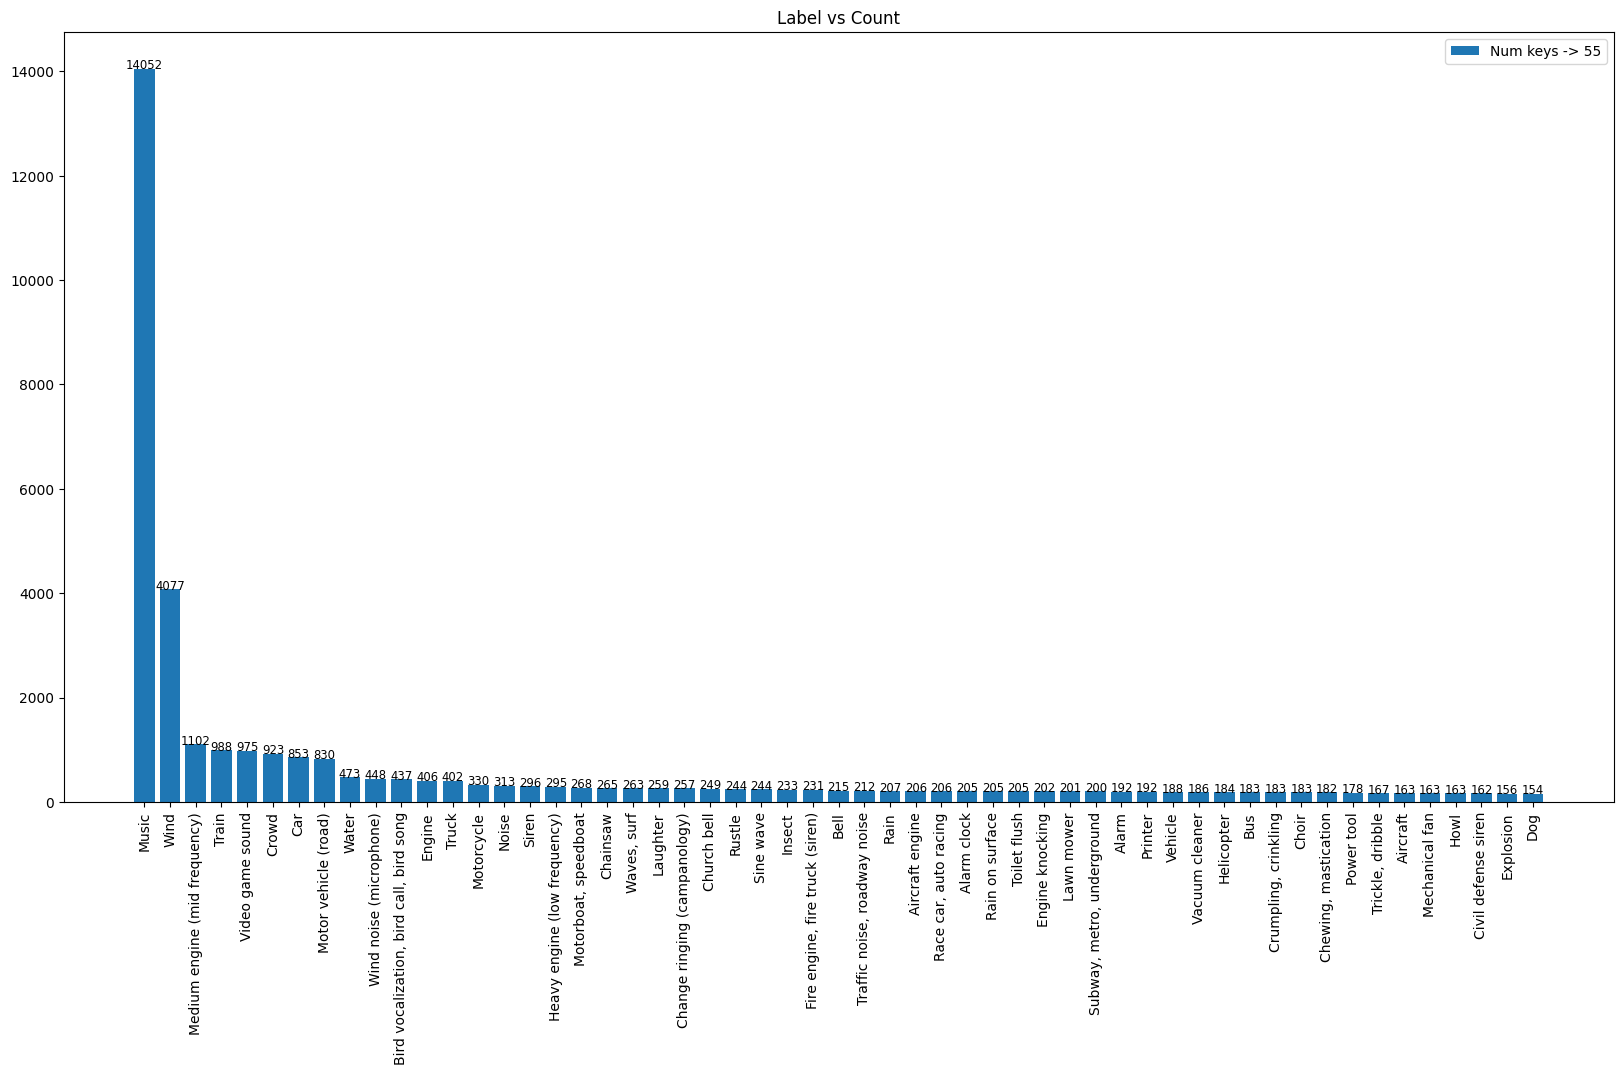

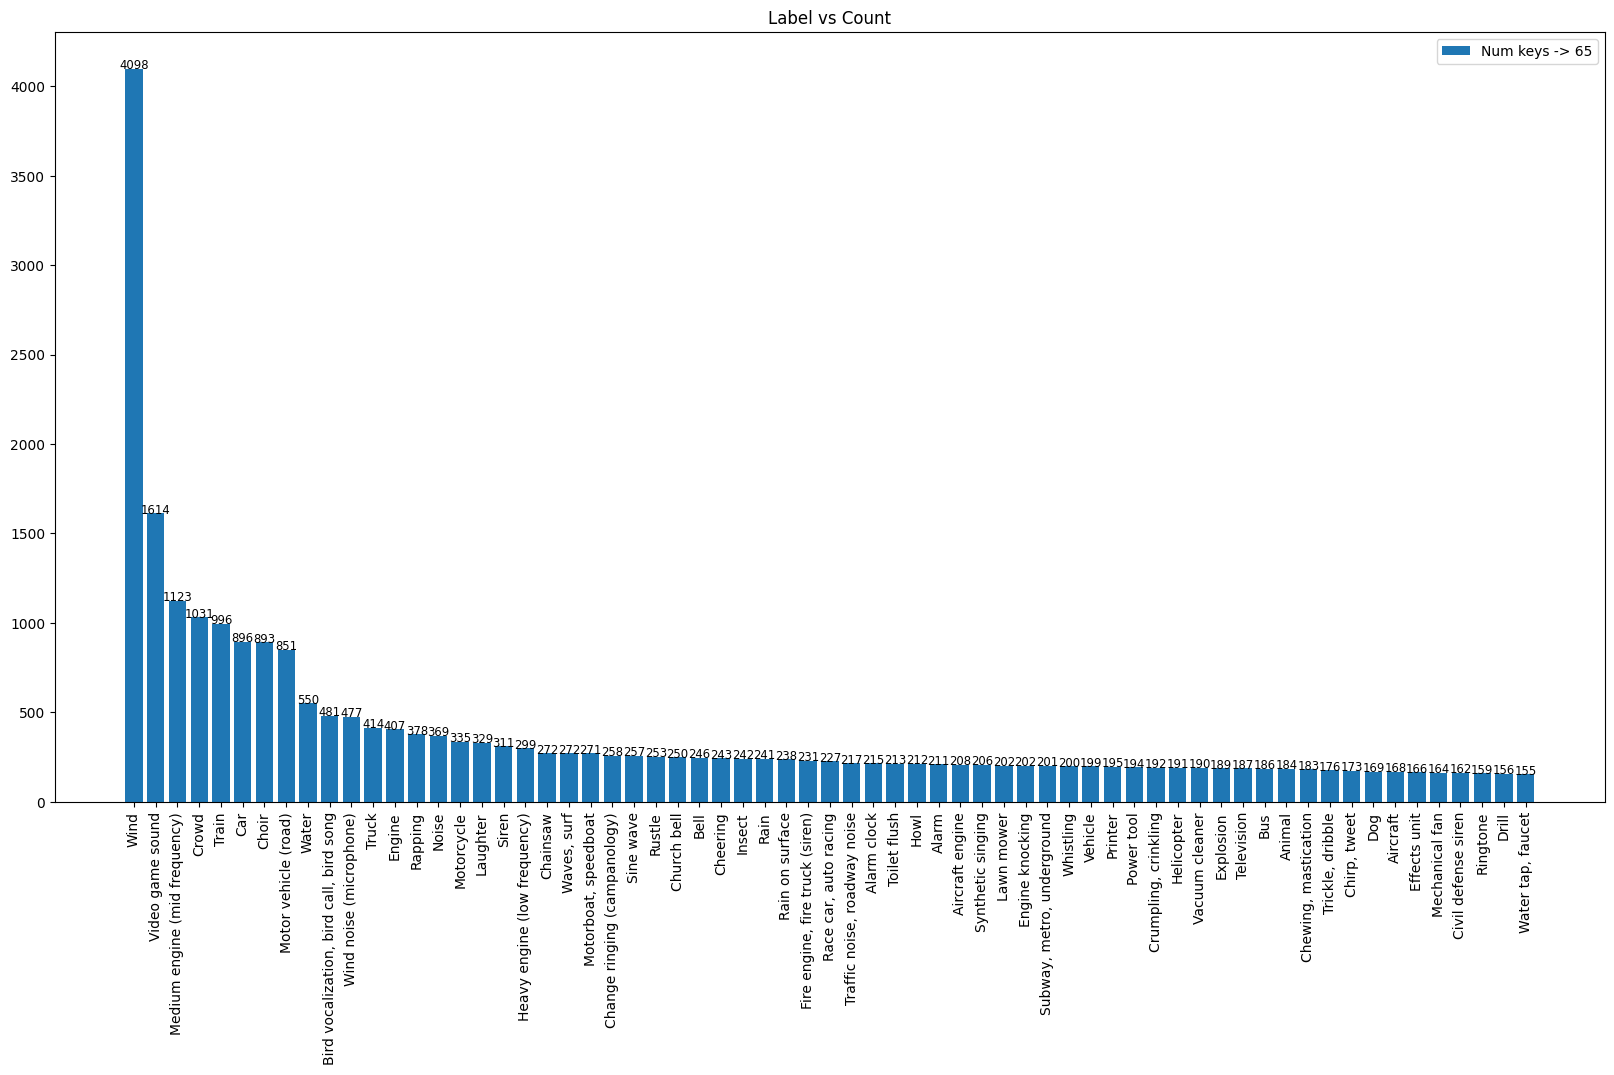

In [38]:

def plot_label_vs_count(label_to_count, mid_to_label,min_num_samples ):
    """
    Plots a bar chart of labels vs. their counts.
    
    Args:
        label_to_count (dict): Dictionary mapping labels to their counts.
        mid_to_label (pd.DataFrame): DataFrame containing label mapping.
        min_num_samples (int): Minimum number of samples for a label to be included in the plot.
    Returns:
        None
    """
    plt.figure(figsize=(20, 10))
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    # keep only labels with samples greater than min_nu_samples and keep key with key_idx
    label_to_count = {k: v for k, v in label_to_count.items() if v > min_num_samples}
    # plot
    plt.bar(label_to_count.keys(), label_to_count.values())
    for i, v in enumerate(label_to_count.values()):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.title('Label vs Count')
    plt.xticks(rotation=90)
    # in plot legend add text saying num keys
    plt.legend([f'Num keys -> {len(label_to_count)}'])
    plt.show()


def process_youtube_data(df, mid_to_label, with_music=False):
    """
    Process YouTube data to find the label with the maximum duration for each YTID,
    and then count and print the labels in descending order of their counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing YouTube segment data.
        mid_to_label (pd.DataFrame): DataFrame containing label mapping.
    
    Returns:
        ytid_to_label_max_duration (dict): mapping YTID to label with the maximum duration.
        label_to_count (dict): mapping label to its count.
    """
    # Convert DataFrame to dictionary records
    data = df.to_dict('records')

    # Initialize the dictionary to store the label with max duration for each YTID
    ytid_to_label = {}

    # Iterate over each row in the data
    for row in data:
        ytid = row['YTID']
        label = row['label']
        duration = row['duration']

        # If the YTID is not in the dictionary, or if the current duration is greater than the stored one
        if (ytid not in ytid_to_label or duration > ytid_to_label[ytid]['duration'] )and not (with_music and (label == '/m/04rlf')):
            ytid_to_label[ytid] = {'label': label, 'duration': duration, 'start_time': row['start_time_seconds'], 'end_time': row['end_time_seconds']}

    # Create a final dictionary with YTID to the label with the max duration
    ytid_to_label_max_duration = {ytid: value['label'] for ytid, value in ytid_to_label.items()}

    # Get label to count dictionary
    label_to_count = {}
    for ytid, label in ytid_to_label_max_duration.items():
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # Sort the label to count dictionary by count in descending order
    label_to_count = dict(sorted(label_to_count.items(), key=lambda item: item[1], reverse=True))

    # Print the labels and their counts in descending order
    # idx = 0
    # for mid, count in label_to_count.items():
    #     idx += 1
    #     label = mid_to_label[mid_to_label['mid'] == mid]['label'].values[0]
    #     print(f'{label} ({idx}) -> {count}')

    return ytid_to_label_max_duration, label_to_count, ytid_to_label

label_selection_config = {
"min_num_samples" : 150,
"max_repeat_ratio" : 2.5
}


ytid_to_label_max_duration, label_to_count, ytid_to_label = process_youtube_data(df, mid_to_label,with_music=False)

plot_label_vs_count(label_to_count, mid_to_label,label_selection_config["min_num_samples"] )

ytid_to_label_max_duration_no_music, label_to_count_no_music, ytid_to_label_no_music = process_youtube_data(df, mid_to_label,with_music=True)

plot_label_vs_count(label_to_count_no_music, mid_to_label,label_selection_config["min_num_samples"] )

## OBSERVATION
- Since most of the youtube videos have music since the source of audioset is youtube, we can skip music as well, but lets have thought reg this fro next iteration of the dataset.
- Advantages: Increase in num labels with given threshold and less skew

In [39]:
# In ytid_to_label keep only keys that have label with count greater than min_num_samples
ytid_to_label = {k: v for k, v in ytid_to_label.items() if label_to_count[v['label']] > label_selection_config["min_num_samples"]}
# convert ytid_to_label to DataFrame
ytid_to_label_df = pd.DataFrame.from_dict(ytid_to_label, orient='index')
ytid_to_label_df = ytid_to_label_df.reset_index()
ytid_to_label_df.columns = ['YTID', 'label','duration', 'start_time', 'end_time']
ytid_to_label_df.head()

,YTID,label,duration,start_time,end_time
0,NQNTnl0zaqU,/m/0_ksk,2.299,1.947,4.246
1,XMl9lI7mKsM,/m/04rlf,10.000,0.000,10.000
2,-FI_F5Lclrg,/m/0bzvm2,10.000,0.000,10.000
3,seUr9_LHUMQ,/m/07pqc89,10.000,0.000,10.000
4,ZvAdd4Jb1xA,/m/03m9d0z,10.000,0.000,10.000


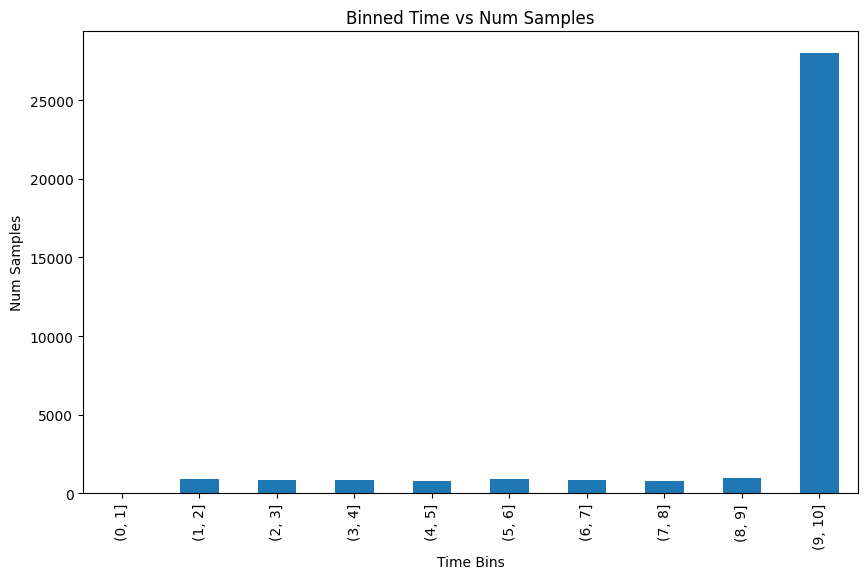

In [40]:
# plot binned time on x with 1sec and num samples in that bin on y
def plot_binned_time_vs_num_samples(df, bin_size=1):
    bins = range(0, int(df['end_time'].max()) + bin_size, bin_size)
    binned = pd.cut(df['duration'], bins)
    num_samples_per_bin = binned.value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    num_samples_per_bin.plot(kind='bar')
    plt.title('Binned Time vs Num Samples')
    plt.xlabel('Time Bins')
    plt.ylabel('Num Samples')
    plt.show()

plot_binned_time_vs_num_samples(ytid_to_label_df)

### OBSERVATION
- Note that most of the labels are almost 10 sec long, this dilutes the purposed of going for a segmented dataset, it is fine for first iteration, but for next iteration we can go for a more fine grained dataset, with multi labels considered for a single video or we can backoff to total Audioset with just labels of noise.
- But anyway as we would randomly select the labels with inverse probabilities upto max of min_num_samples x max_repeat_ration we can avoid this skew.

In [41]:
# save df to json
ytid_to_label_df.to_json('/disk1/audioset/annotations/it1_audioset_anns.json', orient='records')

### LOAD ABOVE FILE FOR FURTHER ANALYSIS

In [1]:
import pandas as pd
import os
import numpy as np

with open('/disk1/audioset/annotations/it1_audioset_anns.json', 'r') as f:
    ytid_to_label_df = pd.read_json(f)
    
# print the top 5 labels with their num occurences that have duration greater than 9 sec
ytid_to_label_df = ytid_to_label_df[ytid_to_label_df['duration'] > 9]
label_to_count = ytid_to_label_df['label'].value_counts()
# print with their counts
print(label_to_count.head(5))

/m/04rlf      11387
/m/03m9d0z     3744
/t/dd00066      944
/m/07jdr        934
/m/03qtwd       863
Name: label, dtype: int64


## Making final dataset and samples selected for dataset to mix with People's speech

In [43]:
from collections import Counter
label_selection_config = {
"min_num_samples" : 150,
"max_repeat_ratio" : 3
}
# select the samples randomly such that a sample is not repeated more than max_repeat_ratio times
samples_per_class = label_selection_config["min_num_samples"] * label_selection_config["max_repeat_ratio"]
final_anns = pd.DataFrame()
all_labels = ytid_to_label_df['label'].unique()
for label in all_labels:
    df = ytid_to_label_df[ytid_to_label_df['label'] == label]
    if len(df) > samples_per_class:
        df = df.sample(samples_per_class, replace=False)
    else:
        df = df.sample(samples_per_class, replace=True)

    final_anns = pd.concat([final_anns, df])

final_anns.reset_index(drop=True, inplace=True)
print(len(final_anns))

24750


In [1]:
plot_binned_time_vs_num_samples(final_anns)
final_anns.to_json('/disk1/audioset/annotations/it1_audioset_anns_final.json', orient='records')

NameError: name 'plot_binned_time_vs_num_samples' is not defined

## LOADING ABOVE FINAL AUDIOSET ANNOTATION FOR DOWNLOADS ANALYSIS

In [6]:
import json
import os
file = '/disk1/audioset/annotations/it1_audioset_anns_final.json'
videos_dir = '/disk1/audioset/train/videos'
videos_list = os.listdir(videos_dir)

data = {}
with open(file, 'r') as f:
    data = json.load(f)
    
count = 0
for ann in data:
    vid = ann['YTID']
    video_id = ''.join(e for e in vid if e.isalnum())
    if video_id+'.mp4' in videos_list:
        count += 1

print(count)


7717
